# Instacart market basket_analysis

    The goal of a data scientist is to derive value from such structured data. In this project, we use analyze over 3 million user grocery shopping orders from more than 200,000 anonymized Instacart users. The dataset used was sourced from Instacart's first public dataset release, “The Instacart Online Grocery Shopping Dataset 2017”, and acquired from Kaggle. Here we attempt to identify key patterns and granular details from this data that would be of use when making business and marketing decision. 

# Setup
## Downloading Packages

In [414]:
# To install the kaggle package in the notebook WARNING Installs System wide
# Download API key from Kaggle from Accounts - Create New Api Token
# Move the downloaded kaggle.json to ~/.kaggle/

# import sys
# !{sys.executable} -m pip install kaggle

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('seaborn-darkgrid')
color = sns.color_palette()
%matplotlib inline

## Downloading Instacart data using the Kaggle API
Unzipping and Cleaning CSV zip files

In [2]:
# Downloading CSV data, unzipping and moving to csv_src folder

# After isntalling the kaggle module and setting kaggle.json api keys
# Download the dataset from the Kaggle
!kaggle competitions download -c instacart-market-basket-analysis

# Custom shell script to unzip all files, remove zips and move csv into csv_src
# The unzip_rm.sh script should be in the same directory as the python notebook file
!chmod u+x unzip_rm.sh
!./unzip_rm.sh

  0%|                                                 | 0.00/804 [00:00<?, ?B/s]
100%|███████████████████████████████████████████| 804/804 [00:00<00:00, 362kB/s]
  0%|                                               | 0.00/1.87k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 1.87k/1.87k [00:00<00:00, 578kB/s]
100%|██████████████████████████████████████| 6.90M/6.90M [00:00<00:00, 8.03MB/s]

100%|████████████████████████████████████████| 795k/795k [00:00<00:00, 7.88MB/s]

 99%|█████████████████████████████████████▋| 31.0M/31.3M [00:04<00:00, 8.21MB/s]
100%|██████████████████████████████████████| 31.3M/31.3M [00:04<00:00, 7.69MB/s]
100%|███████████████████████████████████████▉| 157M/157M [00:21<00:00, 8.23MB/s]
100%|████████████████████████████████████████| 157M/157M [00:21<00:00, 7.78MB/s]
  0%|                                                | 0.00/220k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 220k/220k [00:00<00:00, 10.5MB/s]
Archive:  aisles.csv.zip
 

## Loading CSV files into DataFrames

In [221]:
# Reading all the datasets from the csv_src folder
csv_folder = 'csv_src/'
aisle = pd.read_csv( csv_folder+'aisles.csv')
orders = pd.read_csv(csv_folder+'orders.csv')
products = pd.read_csv(csv_folder+'products.csv')
departments = pd.read_csv( csv_folder+'departments.csv')
order_prior = pd.read_csv(csv_folder+'order_products__prior.csv') 
order_train = pd.read_csv(csv_folder+'order_products__train.csv')

## Setting the ids as index
#### Setting NAs to zeros

In [222]:
# Setting the correct indexes for the data sets

orders.set_index('order_id', inplace=True)
products.set_index('product_id', inplace=True)
aisle.set_index('aisle_id', inplace=True)
departments.set_index('department_id', inplace=True)
orders = orders.fillna(0) # Setting the NaNs to 0. i.e. sets the days since order to 0 for 1st orders

## Taking a look at all available data

In [223]:
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0.0
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0


In [224]:
products.head()

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


In [225]:
departments.head()

,department
department_id,
1,frozen
2,other
3,bakery
4,produce
5,alcohol


In [226]:
aisle.head()

,aisle
aisle_id,
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation


In [227]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [228]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [229]:
print(aisle.shape, products.shape, departments.shape, order_train.shape, order_prior.shape, orders.shape)

(134, 1) (49688, 3) (21, 1) (1384617, 4) (32434489, 4) (3421083, 6)


## Joining the products dframe with departments and aisle dframes

In [230]:
# Doing inner joins on the products and the departments and the aisle by the department_id and aisle_id respectively
product_comb = products.reset_index().set_index('department_id').join(departments, how="inner")
product_comb = product_comb.reset_index().set_index('aisle_id').join(aisle, how="inner")

In [231]:
# Setting the index to 'product_id' and sorting it
product_comb = product_comb.reset_index().set_index('product_id')
product_comb.sort_index(axis=0, ascending=True, kind='quicksort', inplace=True)

In [232]:
product_comb.head()

,aisle_id,department_id,product_name,department,aisle
product_id,,,,,
1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,104,13,All-Seasons Salt,pantry,spices seasonings
3,94,7,Robust Golden Unsweetened Oolong Tea,beverages,tea
4,38,1,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen,frozen meals
5,5,13,Green Chile Anytime Sauce,pantry,marinades meat preparation


## Functions to generate seaborn hist count and matplotlib bar plots

In [456]:
def hist_count_plots(dframe, x_axis, _title, _xlabel, _ylabel, color_index, fig_size=(15,8), title_size=24):
   
    plt.figure(figsize=fig_size)
    sns.countplot(x=x_axis, data=dframe, color=color[color_index])
    plt.title(_title, fontsize=title_size)
    plt.xlabel(_xlabel, fontsize=13)
    plt.ylabel(_ylabel, fontsize=13)
    # Setting the x tick label sizes
    if x_axis == "Order_count":
        plt.tick_params(axis='both', which='major', labelsize=12)
    else:
        plt.tick_params(axis='both', which='major', labelsize=16)
    
    if x_axis == "order_dow":
        plt.xticks( [0,1,2,3,4,5,6],["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"] )
    plt.show()   

def bar_plot(dframe, _xlabel, _ylabel, _title, fig_size=(18,8), title_size=18):
    dframe.plot(kind='bar', figsize=fig_size)
    plt.xlabel(_xlabel, fontsize=14)
    plt.ylabel(_ylabel, fontsize=14)

    plt.tick_params(axis='both', which='major', labelsize=17)
    plt.xticks()
    plt.title(_title, fontsize=title_size)

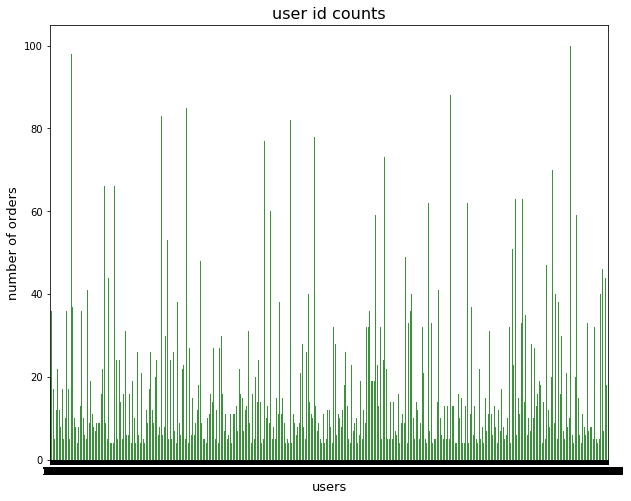

In [27]:
hist_count_plots(orders.iloc[:1000000,:], 'user_id', 'user id counts', "users", "number of orders", 2)

### The above plot shows that most users order on average 16 items or a median of 10 over the course of a year based on the dataset while the minimum and the maximum number of orders are 4 and 100 respectively. But we can clearly see the users who order a hundred items are the outliers who order items in bulk. These outliers are distorting our mean which is larger than our median number of orders for each user.

## Generating a dframe with total order counts for each user

In [438]:
user_order_count_df = orders.groupby('user_id').user_id.count()
user_order_count_df.describe()
user_order_count_df = user_order_count_df.to_frame()
user_order_count_df = user_order_count_df.rename(columns={'user_id': 'Order_count'})

## Descriptive Statistics on the number of orders by each user
### 

In [235]:
user_order_count_df.describe()

,Order_count
count,206209.000000
mean,16.590367
std,16.654774
min,4.000000
25%,6.000000
50%,10.000000
75%,20.000000
max,100.000000


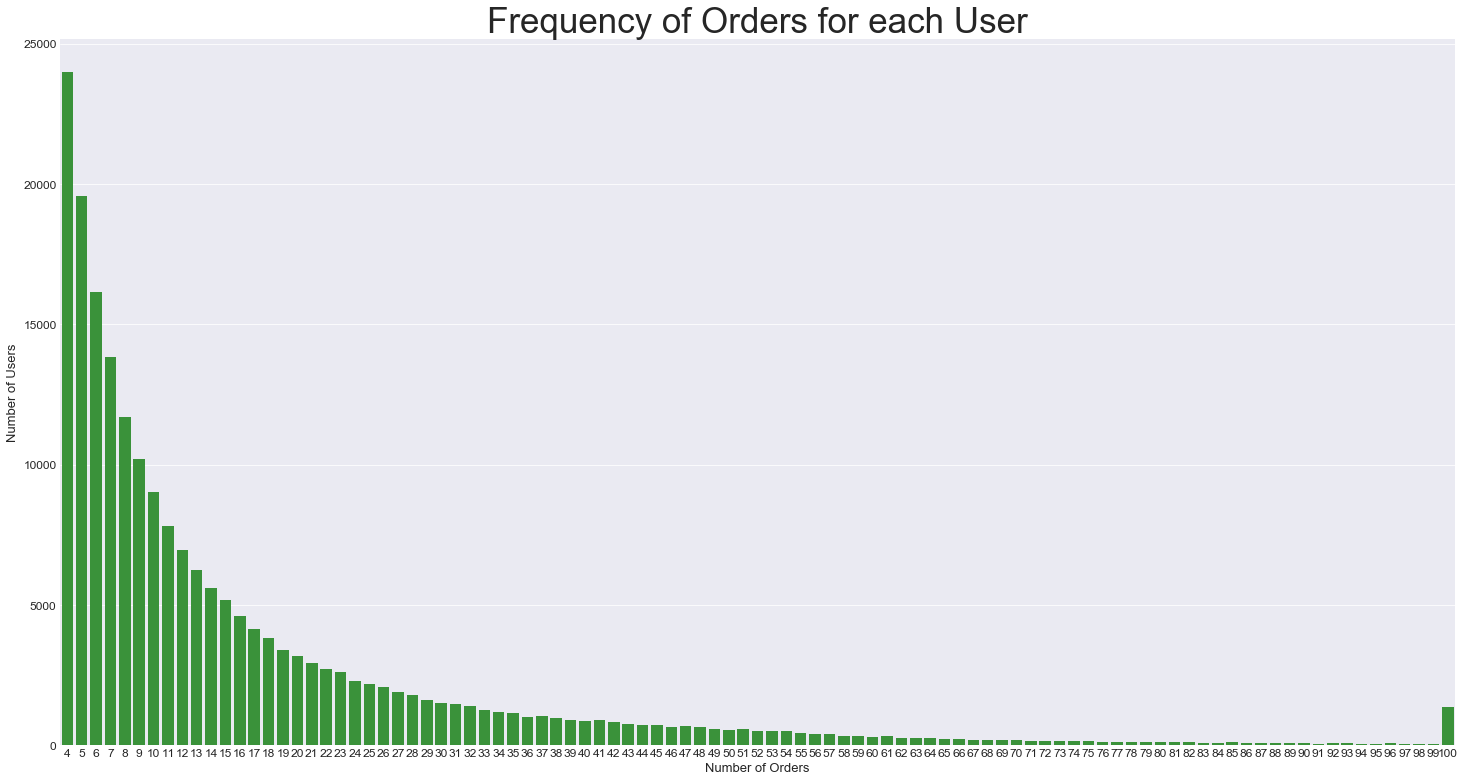

In [457]:
hist_count_plots(user_order_count_df ,"Order_count", "Frequency of Orders for each User",
                 "Number of Orders", "Number of Users", 2, fig_size=(25,13), title_size=35 )

## Looking at Order Frequency by the hour of the day

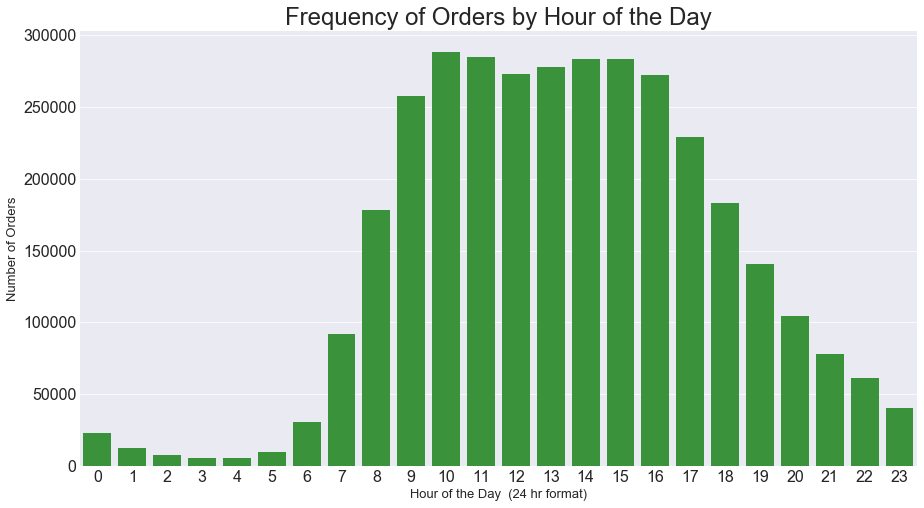

In [458]:
hist_count_plots(orders ,"order_hour_of_day", "Frequency of Orders by Hour of the Day",
                 "Hour of the Day  (24 hr format)", "Number of Orders", 2)

## Looking at Order Frequency by the days of the Week

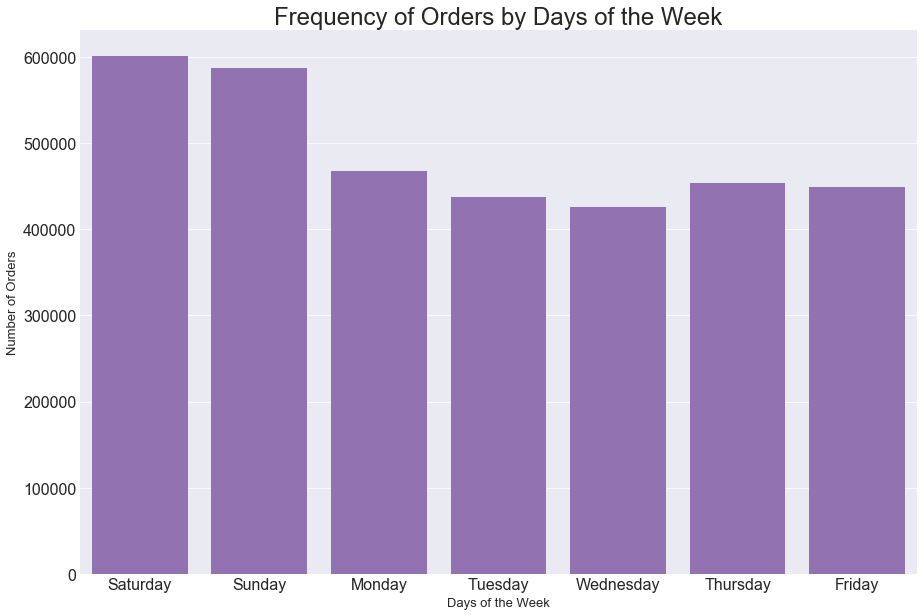

In [459]:
hist_count_plots(orders, "order_dow", "Frequency of Orders by Days of the Week",
                 "Days of the Week", "Number of Orders", 4, fig_size=(15,10))

## Continuous bivariate density of orders between day of the week vs hour of the day
### This plots a two way distribution that corroborates what we have seen in the plots above where orders are concentrated on the weekends and from 8 am to 6 pm.
Plot methods derived from https://seaborn.pydata.org/tutorial/distributions.html

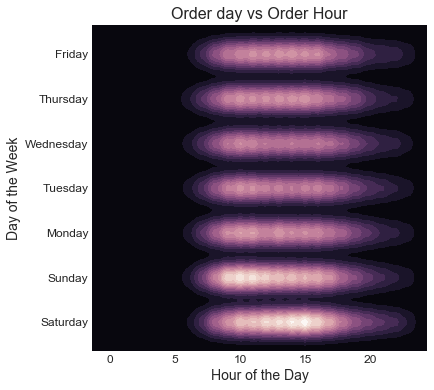

In [452]:
# using a small sample for kernel density axes 
smallset = orders[0:100000]

f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(smallset.order_hour_of_day, smallset.order_dow, cmap=cmap, n_levels=15, shade=True);
plt.title("Order day vs Order Hour", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Day of the Week", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.yticks([0,1,2,3,4,5,6],["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])
plt.show()

## Alternate Continuous bivariate density of orders between day of the week and hour of the day

### Again we see the same concentrated data points for the weekends ( Day 0 and 1 ) from around 8 am to 6 pm

Order day vs Order Hour


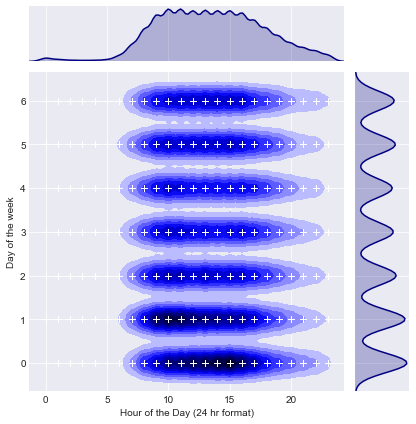

In [244]:
print("Order day vs Order Hour")
print("0 to 6 represent days of the week: Saturday, Sunday")
kde2 = sns.jointplot(x="order_hour_of_day", y="order_dow", data=smallset, kind="kde", color="navy")
kde2.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
kde2.ax_joint.collections[0].set_alpha(0)
kde2.set_axis_labels("Hour of the Day (24 hr format)", "Day of the week")

## Frequency Distribution by days since prior order
### We can see that frequency of orders for days_since_prior_order peak at 7 days and 30 days. For the 7 days, again from the data plots above we have seen that people order the most during weekends and this gives a reordering period of 7 days. For the 30 day reorder period, the instacart data includes reordering information for users who last ordered 30 days ago or more than that. These would be people who order in bulk or those who order very infrequently.

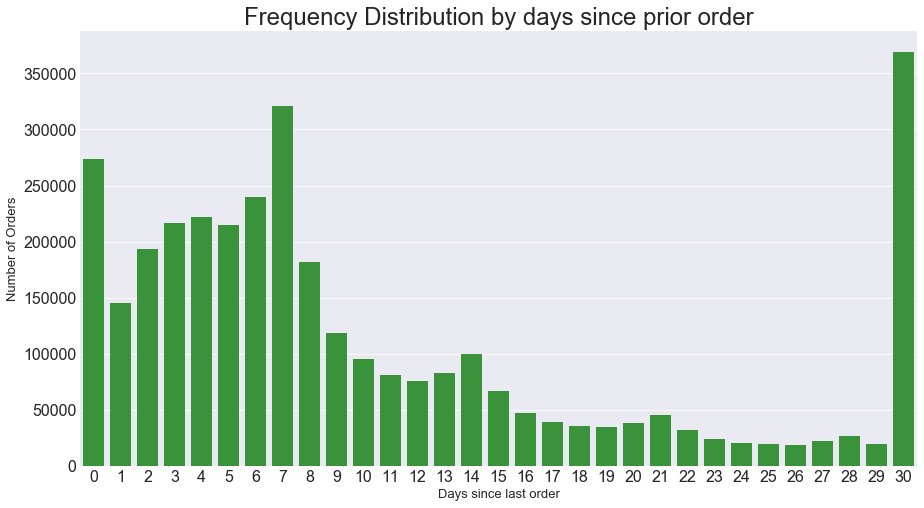

In [460]:
# Generating a dataframe with one column 'days_since_prior_order'
prior_order = orders[['days_since_prior_order']].astype(np.int64) 
hist_count_plots(prior_order, "days_since_prior_order", "Frequency Distribution by days since prior order",
                 "Days since last order", "Number of Orders", 2)

## Alternate view of Frequency Density cross between days since prior order and the day of the week
#### We can see that we have denser regions around 7 days since last orderd and days 0 and 1 which are Saturday and Sunday respectively. This can be explained by the fact that the majority people tend to order groceries during weekends after each week hence the density at days since order = 7 and days =  0 and 1. This observation is also corroborated by our plots above.

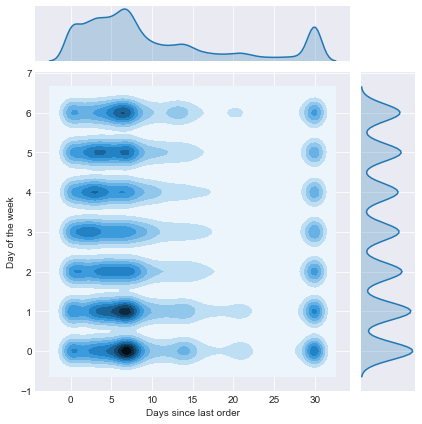

In [246]:
kde3 = sns.jointplot(smallset.days_since_prior_order, smallset.order_dow, data=smallset, kind="kde")
kde3.set_axis_labels("Days since last order", "Day of the week")

## Joining our product_comb and order_prior data frames

In [247]:
# Doing left joins on the products and the departments and the aisle by the department_id and aisle_id respectively
product_prior_comb = order_prior.set_index('product_id').join(product_comb, how="inner")
product_prior_comb.head()

,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle
product_id,,,,,,,,
1,1107,7,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,5319,3,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,7540,4,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,9228,2,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,9273,30,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


## Grouping all the product orders by their departments
And Generating a Order Frequency by Department bar chart

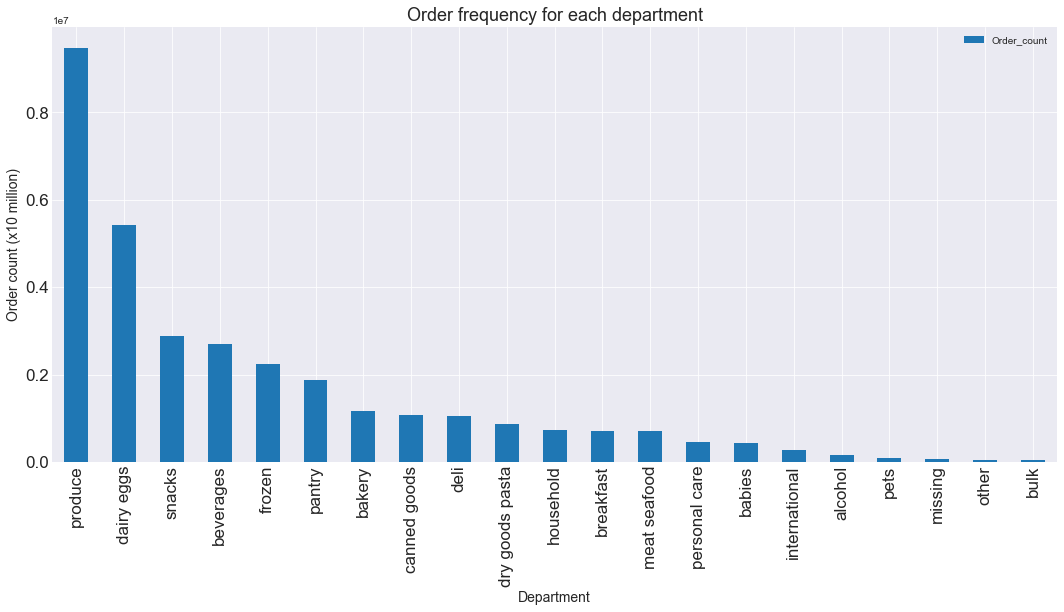

In [461]:
department_count_df = product_prior_comb.groupby('department').department.count()
department_count_df = department_count_df.to_frame()
department_count_df = department_count_df.rename(columns={'department': 'Order_count'})
department_count_df.sort_values(by='Order_count', ascending=False, inplace=True)
bar_plot(department_count_df, "Department", "Order count (x10 million)", "Order frequency for each department")

## We can clearly see that the most heavily ordered items are ordered from the produce section. 
We can hypothesize this observation with the explanation that items in produce like fruits and vegetables go bad quickly and people order them frequently to keep the supplies replenished. While the items categorized in the bulk department are ordered infrequently since they last the most.

## Pie Chart showing Top Ten department breakdown

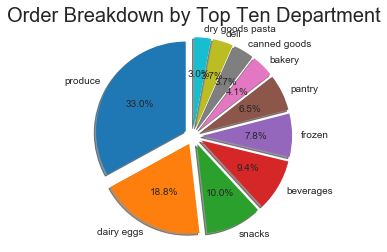

In [455]:
# Generating a percentage column for the order counts for each department
department_count_df['% of total orders'] = (
    department_count_df.Order_count / department_count_df.Order_count.sum())*100

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = department_count_df.index[:10]
sizes = department_count_df.iloc[:10,1]
explode = [ 0.1 for i in range(10) ] #(department_count_df.shape[0])]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Order Breakdown by Top Ten Department", fontsize=20)

plt.show()

## Distribution of departments and reorder rates
We are interested to see if certain departments are the first items or last items to be ordered.

This could affect which items we want to be showing in marketing materials

Perhaps people who order these items then go on to order more items

In [398]:
# We check if certain departments have higher reorder rates. 
# Do inner join betwee the orders and the product table to get product department
MergedProductsDatabase = order_prior.merge(
    products, left_on='product_id', right_on='product_id', how='inner')[['department_id', 'add_to_cart_order']]

# Inner join to get the department name attached
MergedProductsDatabase = MergedProductsDatabase.merge(departments, left_on = 'department_id', right_on='department_id', how='inner')[['department', 'add_to_cart_order']]

### What's the mean item number in the customer cart is items from each department

In [399]:
MergedProductsDatabaseMean = MergedProductsDatabase.groupby(['department'],as_index=False).mean().sort_values(by=['add_to_cart_order'])
print(MergedProductsDatabaseMean)
MergedProductsDatabaseMean.describe()

         department  add_to_cart_order
0           alcohol           5.428346
3         beverages           6.976699
7        dairy eggs           7.495423
18             pets           7.718544
19          produce           8.022875
2            bakery           8.084397
15            other           8.277645
5              bulk           8.399040
11        household           8.492163
13     meat seafood           8.528225
8              deli           8.693815
17    personal care           8.752753
10           frozen           8.996414
4         breakfast           9.124044
20           snacks           9.187743
14          missing           9.339489
16           pantry           9.593425
12    international           9.947061
6      canned goods           9.947258
9   dry goods pasta          10.212863
1            babies          10.575925


,add_to_cart_order
count,21.000000
mean,8.656864
std,1.180297
min,5.428346
25%,8.084397
50%,8.693815
75%,9.339489
max,10.575925


In [400]:
# What's the average item number in the customer cart is items from each department
MergedProductsDatabaseMedian = MergedProductsDatabase.groupby(['department'],as_index=False).median().sort_values(by=['add_to_cart_order'])
print(MergedProductsDatabaseMedian)

         department  add_to_cart_order
0           alcohol                  3
3         beverages                  5
18             pets                  6
2            bakery                  6
5              bulk                  6
15            other                  6
7        dairy eggs                  6
19          produce                  6
11        household                  6
17    personal care                  7
14          missing                  7
13     meat seafood                  7
10           frozen                  7
8              deli                  7
4         breakfast                  7
20           snacks                  7
9   dry goods pasta                  8
6      canned goods                  8
16           pantry                  8
12    international                  8
1            babies                  9


In [402]:
#Place code to construct graph here.
def vbar_plots_cartpositions(dframe1,dframe2, x_axis, _title, _xlabel, _ylabel, color_index):
    plt.figure(figsize=(10,5))
    plt.grid(True)
    sns.barplot(dframe1.iloc[:,0],dframe1.iloc[:,1],color="blue", alpha=0.5,saturation=.7, label='Median position')
    sns.barplot(dframe2.iloc[:,0],dframe2.iloc[:,1],color="green", alpha=0.5,saturation=.7, label = 'Mean position')
    plt.legend(loc='upper left')
    plt.title(_title, fontsize=16)
    plt.xlabel(_xlabel, fontsize=13)
    plt.ylabel(_ylabel, fontsize=13)
    plt.xticks( rotation=70, fontsize=13)
    plt.show()

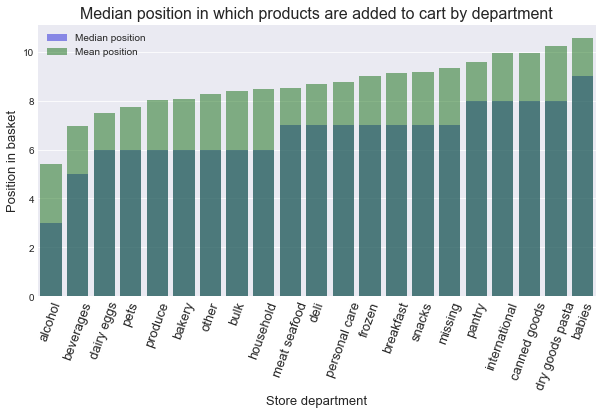

In [403]:
vbar_plots_cartpositions(MergedProductsDatabaseMedian,MergedProductsDatabaseMean,
                         'department', 'Median position in which products are added to cart by department',
                         'Store department','Position in basket', 2)

## Do certain departments get more popular as the number of days since last order increases.
This can affect which products from which departments to show after X number of days since the customer visited the site.

In [404]:
# Inner join the orders items to get the product ID
# Since we inner join on the order id and not other values we need to consider validity. 
MergedProductsDatabase = order_prior.merge(orders[(
    orders.days_since_prior_order >= 0) & (orders.days_since_prior_order <= 31)], left_on='order_id', right_on='order_id', how='inner')[['days_since_prior_order', 'product_id']]


# Inner join with products table to obtain department ID.
MergedProductsDatabase = MergedProductsDatabase.merge(
    products, left_on='product_id', right_on='product_id', how='inner')[['days_since_prior_order', 'department_id']]

# Inner join with departments table to obtain department Name from ID.
MergedProductsDatabase = MergedProductsDatabase.merge(
    departments, left_on='department_id', right_on='department_id', how='inner')[['days_since_prior_order', 'department']]

### First stores the day, second stores a list of department. Third stores a value.
This is where each day's data will be stored

In [405]:
priorOrderDay = [0]*31

# Each day will have a department list that contains the headers and it's respective number of occurances
department_list = [departments.department.unique().tolist(), [0]*len(departments.department.unique())]

for day in range(31):
    # This kaggle dataset only reaches 31 days. It's likely truncated
    thisDay = MergedProductsDatabase[(MergedProductsDatabase.days_since_prior_order == day)]
    
    # We select this day and save it's occurances into the departmentList's number of occurances section.
    for row in thisDay.itertuples():
        department_list[1][department_list[0].index(row.department)] += 1
    priorOrderDay[day] = department_list
    department_list = [departments.department.unique().tolist(), [0]*len(departments.department.unique())]

In [406]:
def line_departmentOrderDay( orderDayList, _title, _xlabel, _ylabel):
    plt.figure(figsize=(20,15))
    plt.grid(True)
#   sns.plot(dframe1.iloc[:,0],dframe1.iloc[:,1],color="blue", alpha=0.5,saturation=.7, label='Median position')
    
    itemsDayArray = {}
    itemList = departments.department.unique().tolist() 
    
    #Initialize the items day array so we can append new values.
    for item in itemList:
        itemsDayArray[item] = []


    for day in orderDayList:
        for i in range(len(itemList)):
            #Append new value for this item for this day onto the itemsDayArray so we can divide it up by date.
            itemsDayArray[day[0][i]].append(day[1][i])
    
    for item in itemList:
        plt.plot(list(range(31)), itemsDayArray[item], label =item)

    plt.xticks( rotation=70, fontsize=13)
    plt.legend(loc='upper left')
    plt.title(_title, fontsize=16)
    plt.xlabel(_xlabel, fontsize=13)
    plt.ylabel(_ylabel, fontsize=13)
    plt.show()

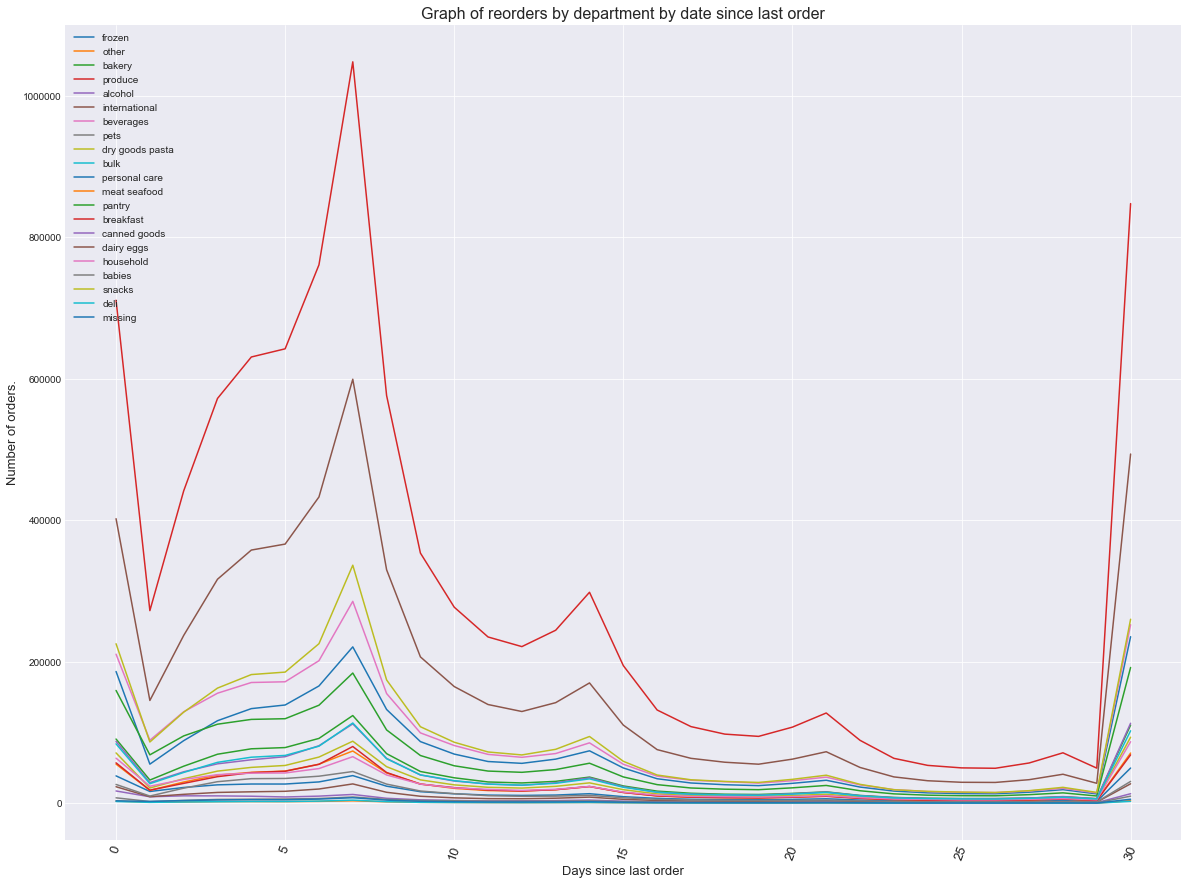

In [407]:
line_departmentOrderDay(priorOrderDay,'Graph of reorders by department by date since last order', 'Days since last order', 'Number of orders.')

## We don't see much of a difference between each individual product since the large scale fluctuations in number of orders between days overpowers the perhaps smaller difference between which items are popular. So, we now attempt to plot the ratio rather than the absolute amount

In [408]:
# We now plot by the percentage (ratio) of each line. This should give us a better idea of which items
# Become more popular as we go along

def line_departmentOrderDayPct( orderDayList, _title, _xlabel, _ylabel):
    plt.figure(figsize=(20,15))
    plt.grid(True)
    
    itemsDayArray = {}
    itemList = departments.department.unique().tolist() 
    
    #Initialize the items day array so we can append new values.
    for item in itemList:
        itemsDayArray[item] = []
        
    for day in orderDayList:
        #Calculate the total amount of orders so we can then determine the ratio
        sum = 0
        for i in range(len(itemList)):
            sum += day[1][i]
        for i in range(len(itemList)):
            #Adds the total ratio into the dictionary
            itemsDayArray[day[0][i]].append(day[1][i]/sum)
    
    #Plots each item on the graph. Mark the label as the name of this item
    for item in itemList:
        plt.plot(list(range(31)), itemsDayArray[item], label =item)

    plt.xticks( rotation=70, fontsize=13)
    #Set the legend so we can identify which line
    plt.legend(loc='upper left')
    plt.title(_title, fontsize=16)
    plt.xlabel(_xlabel, fontsize=13)
    plt.ylabel(_ylabel, fontsize=13)
    plt.show()

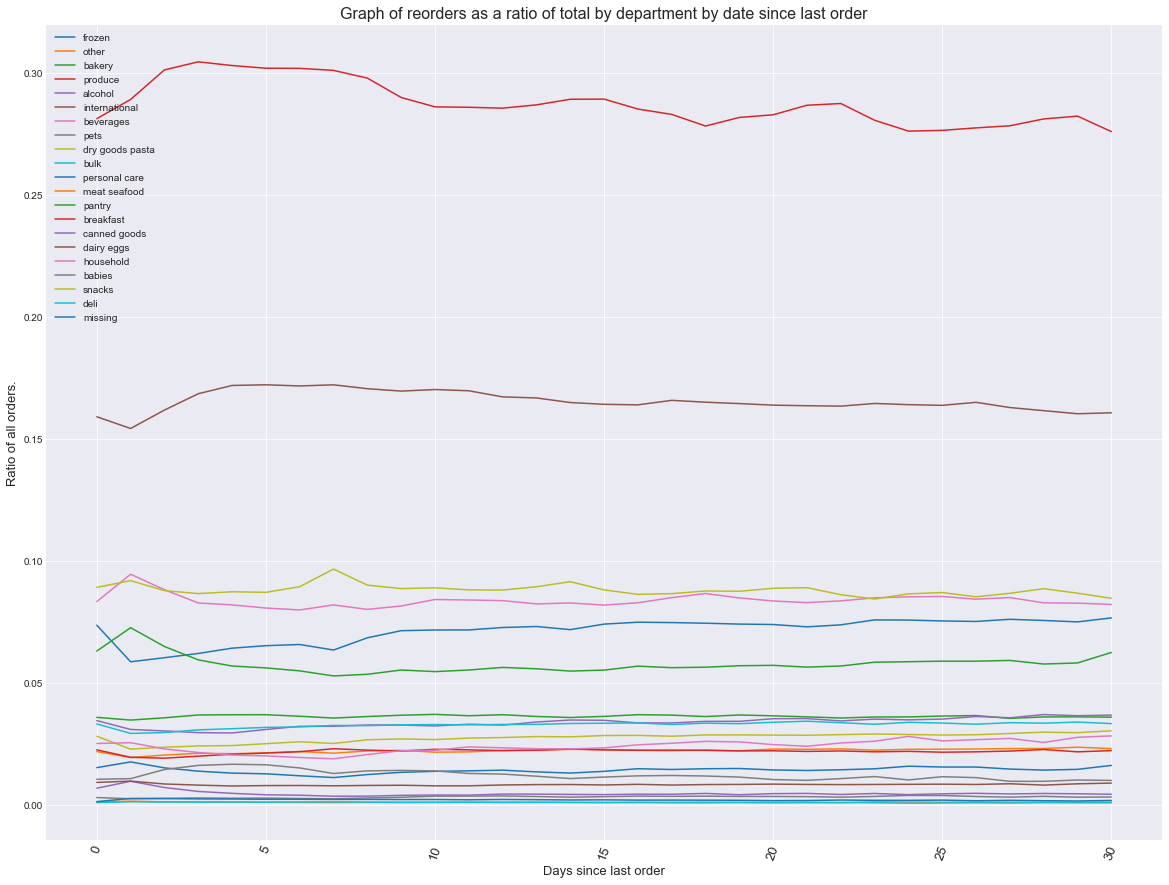

In [409]:
line_departmentOrderDayPct(priorOrderDay,
                           'Graph of reorders as a ratio of total by department by date since last order', 'Days since last order', 'Ratio of all orders.')

## Now we calculate the regression for some of these values. 

## Our original hypothesis was to see if higher last order days would result in certain departments being less common. (People who order every 25 days might get less consumables)?

In [412]:
def regressionCalc(orderDayList,departmentName):

    itemsDayArray = {}
    itemList = departments.department.unique().tolist() 
    
    # Initialize the items day array so we can append new values.
    for item in itemList:
        itemsDayArray[item] = []
        
    for day in orderDayList:
        # Calculate the total amount of orders so we can then determine the ratio
        sum = 0
        for i in range(len(itemList)):
            sum += day[1][i]
        for i in range(len(itemList)):
            #Adds the total ratio into the dictionary
            itemsDayArray[day[0][i]].append(day[1][i]/sum)
    
    # Stats models refrenced from http://www.statsmodels.org/devel/examples/notebooks/generated/formulas.html
    selected = pd.DataFrame({"departmentRatio": itemsDayArray[departmentName], "Days": list(range(31))})
    result = sm.ols(formula="departmentRatio ~ Days", data=selected).fit()
    print(result.summary())

In [415]:
regressionCalc(priorOrderDay, 'produce')

                            OLS Regression Results                            
Dep. Variable:        departmentRatio   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     40.75
Date:                Fri, 21 Dec 2018   Prob (F-statistic):           5.60e-07
Time:                        06:02:54   Log-Likelihood:                 116.73
No. Observations:                  31   AIC:                            -229.5
Df Residuals:                      29   BIC:                            -226.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2987      0.002    147.018      0.0

## We calculate the regression statistic and find that while R squared seems to be high, which suggests that there is a strong correlation between the ratio of produce and the time since last ordered, however, the F statistic is very big. This suggests that there is a very large probability that the data is not explained by our hypothesis but rather by external factors
Lets do it for a few more departments

In [416]:
regressionCalc(priorOrderDay, 'dairy eggs')

                            OLS Regression Results                            
Dep. Variable:        departmentRatio   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     3.949
Date:                Fri, 21 Dec 2018   Prob (F-statistic):             0.0564
Time:                        06:03:59   Log-Likelihood:                 127.79
No. Observations:                  31   AIC:                            -251.6
Df Residuals:                      29   BIC:                            -248.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1680      0.001    118.106      0.0

In [417]:
regressionCalc(priorOrderDay, 'canned goods')

                            OLS Regression Results                            
Dep. Variable:        departmentRatio   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     93.42
Date:                Fri, 21 Dec 2018   Prob (F-statistic):           1.42e-10
Time:                        06:04:14   Log-Likelihood:                 170.84
No. Observations:                  31   AIC:                            -337.7
Df Residuals:                      29   BIC:                            -334.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0308      0.000     86.888      0.0

## We see similar patters, either really low R squared or very high F statistics. It appears that our hypothesis was not quite correct

## Grouping all the products by the number of times they were ordered

In [251]:
product_count_df = product_prior.groupby('product_name').product_name.count()
product_count_df = product_count_df.to_frame()
product_count_df = product_count_df.rename(columns={'product_name': 'Order_count'})

#### Getting a description of the product count dataframe

In [253]:
product_count_df.describe()

,Order_count
count,49677.000000
mean,652.907563
std,4792.114416
min,1.000000
25%,17.000000
50%,60.000000
75%,260.000000
max,472565.000000


## Top ten most ordered products
### After sorting the product_count_df dataframe by Order_count in a descending manner, we can see that the most ordered item is Banana followed by Bag of Organic Bananas

In [257]:
desc_product_count_df = product_count_df.sort_values(by=['Order_count'], ascending=False)
desc_product_count_df.head(10)

,Order_count
product_name,
Banana,472565
Bag of Organic Bananas,379450
Organic Strawberries,264683
Organic Baby Spinach,241921
Organic Hass Avocado,213584
Organic Avocado,176815
Large Lemon,152657
Strawberries,142951
Limes,140627


## Joining our product_comb and order_train data frames using inner join for machine learning analysis

In [275]:
product_prior_comb.head(3)

,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle
product_id,,,,,,,,
1,1107,7,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,5319,3,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,7540,4,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [434]:
# Completing the actual join operation with an inner join
product_train_comb = order_train.set_index('product_id').join(product_comb, how="inner")
print(product_prior_comb.shape, product_train_comb.shape)
product_train_comb.head(3)

(32434489, 8) (1384617, 8)


,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle
product_id,,,,,,,,
1,6695,7,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,48361,9,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,63770,4,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


# Simple Machine Learning using Scikit Learn
#### Model derived from the Scikit Learn website https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

## Here we are creating a train and a test set for the full analysis
#### However for our current tests we are not using the test set but using untrained sections of the train set for tests

In [283]:
orders_train_filter = (orders['eval_set']=='train')
orders_test_filter = (orders['eval_set']=='test')
train_set = orders[orders_train_filter]
test_set = orders[orders_test_filter]

## Joining the train_set with product_train_comb to create a compete dataframe

In [418]:
orders_product_train_comb = train_set.reset_index().set_index(
    'order_id').join(product_train_comb.set_index('order_id'), how="inner")

# Join with test set creates no data
# orders_product_test_comb = test_set.reset_index().set_index(
#     'order_id').join(product_prior_comb.set_index('order_id'), how="inner")
orders_product_train_comb.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle
order_id,,,,,,,,,,,,,
1,112108,train,4,4,10,9.0,3,0,83,4,Organic Celery Hearts,produce,fresh vegetables
1,112108,train,4,4,10,9.0,2,1,108,16,Organic 4% Milk Fat Whole Milk Cottage Cheese,dairy eggs,other creams cheeses
1,112108,train,4,4,10,9.0,6,0,24,4,Bag of Organic Bananas,produce,fresh fruits
1,112108,train,4,4,10,9.0,8,1,21,16,Organic Whole String Cheese,dairy eggs,packaged cheese
1,112108,train,4,4,10,9.0,5,1,95,15,Lightly Smoked Sardines in Olive Oil,canned goods,canned meat seafood


In [332]:
orders_product_train_comb.shape

(1384617, 13)

## Here we are training K nearest neighbour classifier machine learning algorithm
### We train it with the order_number, order_day_of_week, order_hour_of_day and days_since_prior_order as the x_train values and the reorder status as the y train for prediction

In [433]:
last_limit_train = 1000000
nearest_neighbour_count=100

# Get the x_train and y_train data arrays from the orders_product_train_comb data frame
X_train = np.array([orders_product_train_comb.loc[:last_limit_train,'order_number'], 
                    orders_product_train_comb.loc[:last_limit_train,'order_dow'], 
                    orders_product_train_comb.loc[:last_limit_train,'order_hour_of_day'],
                    orders_product_train_comb.loc[:last_limit_train,'days_since_prior_order']
                   ])
# To ensure the dimension of the data is last_limit_train rows and four rows
X_train = np.transpose(X_train)
y_train = np.array(orders_product_train_comb.loc[:last_limit_train,'reordered'])

neigh = KNeighborsClassifier(n_neighbors=nearest_neighbour_count)
# Train the knearest neighbours classifier
neigh.fit(X_train, y_train)

# Checking a random row for prediction accuracy
out_row = 1085057
out = [[orders_product_train_comb.iloc[out_row, 2], 
                    orders_product_train_comb.iloc[out_row, 3], 
                    orders_product_train_comb.iloc[out_row, 4],
                    orders_product_train_comb.iloc[out_row, 5]
                   ]]
print('Predicted Reorder status for product %s for user %d is %d\n\n' % (
    orders_product_train_comb.iloc[out_row, 11], orders_product_train_comb.iloc[out_row, 0], neigh.predict(out)))

print(("Actual Reorder status for product " 
         + str(orders_product_train_comb.iloc[out_row, 11]) + ' for user ' \
       + str(orders_product_train_comb.iloc[out_row, 0]) + " is "+str(orders_product_train_comb.iloc[out_row, 7])),
      orders_product_train_comb.iloc[out_row, :], sep='\n\n')

Predicted Reorder status for product deli for user 119255 is 1


Actual Reorder status for product deli for user 119255 is 1

user_id                                 119255
eval_set                                 train
order_number                                17
order_dow                                    3
order_hour_of_day                           16
days_since_prior_order                      21
add_to_cart_order                            4
reordered                                    1
aisle_id                                    67
department_id                               20
product_name                   Original Hummus
department                                deli
aisle                     fresh dips tapenades
Name: 2681329, dtype: object


## Up here, we can see that the reorder predicted status for the product 'deli' for the user 119255 was 1 or the algorithm predicted user 119255 reordered this item and they actually did.

### Of course, this machine learning algorithm will not be 100% accurate and we run tests below to check the accuracy of the models based on the number of test data we feed it
The last_limit_train variable dictates the number of data sets to be used to train the model.
The nearest_neighbour_count variable sets the number of n_neighbours the algorithm should use to classify the results.
THe higher this number the more likely that the model will incorporate random noises as significant indicators in its model

In [396]:
last_limit_train = 10000
nearest_neighbour_count=10

# Get the x_train and y_train data arrays from the orders_product_train_comb data frame
X_train = np.array([orders_product_train_comb.loc[:last_limit_train,'order_number'], 
                    orders_product_train_comb.loc[:last_limit_train,'order_dow'], 
                    orders_product_train_comb.loc[:last_limit_train,'order_hour_of_day'],
                    orders_product_train_comb.loc[:last_limit_train,'days_since_prior_order']
                   ])
# To ensure the dimension of the data is last_limit_train rows and four rows
X_train = np.transpose(X_train)
y_train = np.array(orders_product_train_comb.loc[:last_limit_train,'reordered'])

neigh = KNeighborsClassifier(n_neighbors=nearest_neighbour_count)
# Train the knearest neighbours classifier
neigh.fit(X_train, y_train)

start, end = 106000, 107000
right_count = 0
total_count = 0

# looping from the start row to end row in the orders_product_train_comb
for i in range(start, end):   
    total_count += 1
    out_row = i
    out = [[orders_product_train_comb.iloc[out_row, 2], 
                        orders_product_train_comb.iloc[out_row, 3], 
                        orders_product_train_comb.iloc[out_row, 4],
                        orders_product_train_comb.iloc[out_row, 5]
                       ]]
    predict = neigh.predict(out)
    actual = orders_product_train_comb.iloc[out_row, 7]
    if predict == actual:
        right_count += 1

print((right_count/total_count) * 100, '%') 

49.6 %


### We can see that with a train set of 10000 values, we a get accuracy of 49.6%

In [425]:
last_limit_train = 500000
nearest_neighbour_count=10

# Get the x_train and y_train data arrays from the orders_product_train_comb data frame
X_train = np.array([orders_product_train_comb.loc[:last_limit_train,'order_number'], 
                    orders_product_train_comb.loc[:last_limit_train,'order_dow'], 
                    orders_product_train_comb.loc[:last_limit_train,'order_hour_of_day'],
                    orders_product_train_comb.loc[:last_limit_train,'days_since_prior_order']
                   ])
# To ensure the dimension of the data is last_limit_train rows and four rows
X_train = np.transpose(X_train)
y_train = np.array(orders_product_train_comb.loc[:last_limit_train,'reordered'])

neigh = KNeighborsClassifier(n_neighbors=nearest_neighbour_count)
# Train the knearest neighbours classifier
neigh.fit(X_train, y_train)

start, end = 106000, 107000
right_count = 0
total_count = 0

for i in range(start, end):   
    total_count += 1
    out_row = i
    out = [[orders_product_train_comb.iloc[out_row, 2], 
                        orders_product_train_comb.iloc[out_row, 3], 
                        orders_product_train_comb.iloc[out_row, 4],
                        orders_product_train_comb.iloc[out_row, 5]
                       ]]
    predict = neigh.predict(out)
    actual = orders_product_train_comb.iloc[out_row, 7]
    if predict == actual:
        right_count += 1

print((right_count/total_count) * 100, '%') 

66.2 %


### But as expected when the train set is 500000 values, we an increase get accuracy of 66.2%